## Importing necessary packages.

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer

## Objective:
####To perform task scheduling based on CPU and Memory allocation in order maximise resource utilisation using Reinforcement Learning methods, such as Q-Learning, Double Q-Learning and Deep Q-Network.

#### Environment Creation

States: No.of tasks to be scheduled (m)

Actions: Selecting a task, Not selecting a task (0/1)

Reward/Penalty based on the "Resources" ([CPU, Memory])

Reward Calculation:

Reward = sum(CPU, Memory)

Penalty = -sum(CPU, Memory)/10

Penalty if:
1. sum(CPU, Memory) > limit
2. Selecting an already scheduled task.


For the purpose of analysing the output with ease the no.of job samples is 1, but the inputs can be altered to handle input dynamically.

In [3]:
class env:
  rand_seed = 10

  def __init__(self, resources, num_tasks):
    np.random.seed(self.rand_seed)
    self.state = np.zeros((num_tasks, 1), dtype=int)
    self.limit = 0

    for lim in resources:
      self.state = np.append(self.state, np.random.randint(lim, size=(num_tasks, 1)), axis=1) #no.of tasks to be sechduled
      self.limit += lim #total reource limiit is sum of resources

    self.reward_matrix = np.zeros((num_tasks, num_tasks+1))
    self.reward = 0

    self.num_tasks_ = num_tasks
    self.resources_ = resources

    #Defining Actions
    self.action_select, self.action_pass = 1, 0
    self.state_actions = {}

    for i in range(num_tasks):
      self.state_actions.__setitem__(i, [self.action_select, self.action_pass])

  def get_initial_state(self):
    st = np.zeros((self.num_tasks_, 1), dtype=int)

    for lim in self.resources_:
      st = np.append(st, np.random.randint(lim, size=(self.num_tasks_, 1)), axis=1)

    self.state = st
    self.reward = 0
    self.reward_matrix = np.zeros((self.num_tasks_, self.num_tasks_+1))
    return self.state

  def get_sum(self,x):
    if x[0] == 1:
      return sum(x)-1
    else:
      return 0

  def get_next_step(self, actionIdx):
   self.reward = 0
   self.done = False

   if self.state[actionIdx][0] == 1:
    sum_res = np.sum(self.state[actionIdx], axis=0)
    sum_res -= 1
    self.reward = -sum_res/10 #penalty for choosing already chosen task
    return self.state, self.reward, self.done

   else:
    self.state[actionIdx][0] = 1

   total_reward = sum(np.apply_along_axis(self.get_sum,1,self.state))
   sum_res = np.sum(self.state[actionIdx], axis=0)
   sum_res -= 1

   if total_reward < self.limit:
    self.reward = sum_res
   else:
    self.reward = -sum_res/10
    self.done = True #since memory limit exceeded

   return self.state, self.reward, self.done

In [28]:
resources = [80, 80] #CPU and Memory limits
num_tasks = 6
mdp_environment = env(resources, num_tasks)

## Q-Learning

In [14]:
def QLearn(environment, num_tasks, gamma, round_dec=2, eps=0.2): #Using Greedy-Epsilon Method

  total_reward = 0
  Q = [[0 for i in range(num_tasks+1)] for j in range(num_tasks)]
  s = environment.get_initial_state()
  scheduled = False
  r_plt = []

  while not scheduled:
    prevQ = copy.deepcopy(Q) #To check for convergence of Q-matrix

    if np.random.random() < eps:
      print("Randomly selected")
      a = np.random.randint(0, num_tasks)
      print(a)
    else:
      print("Greedily selected")
      Q_temp = np.array(Q)
      idx = np.unravel_index(Q_temp.argmax(), Q_temp.shape)
      idx = list(idx)
      a = idx[0]
      print(a)

    state, R, done = environment.get_next_step(a)
    total_reward += R
    r_plt.append(total_reward)

    print(state, R, done, total_reward)

    for i in range(len(Q)):
      for j in range(len(Q[0])):
        if done == True: #Scheduling is done
          break
        Q[i-1][j-1] = round(R + gamma*max(Q[j-1]), round_dec)

    if prevQ == Q:
      return Q, total_reward, r_plt

In [24]:
Q, rewards, r_plt = QLearn(mdp_environment, num_tasks, 0.8)

Greedily selected
0
[[ 1 28 13]
 [ 0 26 77]
 [ 0  1 25]
 [ 0  2 61]
 [ 0 60 40]
 [ 0 51  6]] 41 False 41
Greedily selected
4
[[ 1 28 13]
 [ 0 26 77]
 [ 0  1 25]
 [ 0  2 61]
 [ 1 60 40]
 [ 0 51  6]] 100 False 141
Greedily selected
4
[[ 1 28 13]
 [ 0 26 77]
 [ 0  1 25]
 [ 0  2 61]
 [ 1 60 40]
 [ 0 51  6]] -10.0 False 131.0
Greedily selected
0
[[ 1 28 13]
 [ 0 26 77]
 [ 0  1 25]
 [ 0  2 61]
 [ 1 60 40]
 [ 0 51  6]] -4.1 False 126.9
Greedily selected
0
[[ 1 28 13]
 [ 0 26 77]
 [ 0  1 25]
 [ 0  2 61]
 [ 1 60 40]
 [ 0 51  6]] -4.1 False 122.80000000000001
Randomly selected
1
[[ 1 28 13]
 [ 1 26 77]
 [ 0  1 25]
 [ 0  2 61]
 [ 1 60 40]
 [ 0 51  6]] -10.3 True 112.50000000000001


Text(0, 0.5, 'Rewards')

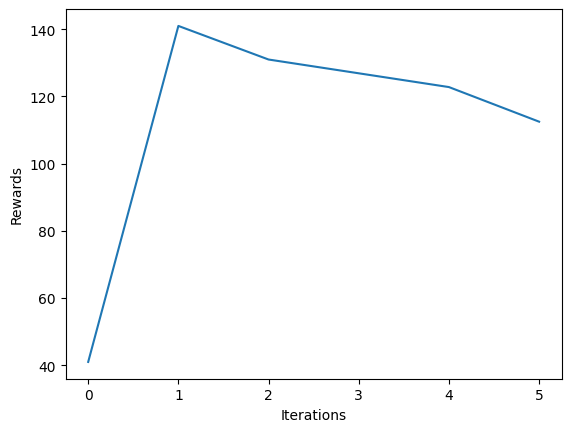

In [25]:
x_plt = []
for i in range(len(r_plt)):
  x_plt.append(i)
plt.plot(x_plt, r_plt)
plt.xlabel("Iterations")
plt.ylabel("Rewards")

The final reward is 112.5

From the graph, there is a sudden pike in the rewards initially, then dropping after a threshold. The model can do better in the exploration-exploitation tradeoff.

## Double Q-Learning

In [29]:
def DoubleQLearn(environment, num_tasks, gamma, round_dec=2, eps=0.2): #Using greedy epsilon method
  r_plt = []
  Q_a =  [ [0 for i in range(num_tasks+1)] for j in range(num_tasks)]
  Q_b =  [ [0 for i in range(num_tasks+1)] for j in range(num_tasks)]
  s = environment.get_initial_state()
  scheduled = False
  total_reward = 0

  Q_table = Q_a + Q_b

  while not scheduled:
    prevQ = copy.deepcopy(Q_table)

    if np.random.random() < eps:
      a = np.random.randint(0, num_tasks)
      print("Randomly selected")
    else:
      print("Greedily selected")
      Q_temp = np.array(Q_table)
      idx = np.unravel_index(Q_temp.argmax(), Q_temp.shape)
      idx = list(idx)
      a = idx[0]
    print(a)
    state, R, done = environment.get_next_step(a)
    total_reward += R
    r_plt.append(total_reward)

    print(state, R, done, total_reward)

    for i in range(len(Q_a)):
      for j in range(len(Q_a[0])):
        if done == True:
          break

        if np.random.rand() < 0.5:
          Q_a[i-1][j-1] = round(R + gamma*max(Q_a[j-1]), round_dec)
        else:
          Q_b[i-1][j-1] = round(R + gamma*max(Q_b[j-1]), round_dec)

    if prevQ == Q_table:
      return Q_table, total_reward, r_plt

In [71]:
Q, rewards, r_plt = DoubleQLearn(mdp_environment, num_tasks, 0.8)

Randomly selected
5
[[ 0 18  6]
 [ 0  1 39]
 [ 0 41 23]
 [ 0  0 24]
 [ 0 44  7]
 [ 1 56 55]] 111 False 111
Greedily selected
3
[[ 0 18  6]
 [ 0  1 39]
 [ 0 41 23]
 [ 1  0 24]
 [ 0 44  7]
 [ 1 56 55]] 24 False 135
Greedily selected
3
[[ 0 18  6]
 [ 0  1 39]
 [ 0 41 23]
 [ 1  0 24]
 [ 0 44  7]
 [ 1 56 55]] -2.4 False 132.6
Greedily selected
3
[[ 0 18  6]
 [ 0  1 39]
 [ 0 41 23]
 [ 1  0 24]
 [ 0 44  7]
 [ 1 56 55]] -2.4 False 130.2
Greedily selected
3
[[ 0 18  6]
 [ 0  1 39]
 [ 0 41 23]
 [ 1  0 24]
 [ 0 44  7]
 [ 1 56 55]] -2.4 False 127.79999999999998
Greedily selected
0
[[ 1 18  6]
 [ 0  1 39]
 [ 0 41 23]
 [ 1  0 24]
 [ 0 44  7]
 [ 1 56 55]] 24 False 151.79999999999998
Greedily selected
0
[[ 1 18  6]
 [ 0  1 39]
 [ 0 41 23]
 [ 1  0 24]
 [ 0 44  7]
 [ 1 56 55]] -2.4 False 149.39999999999998
Greedily selected
3
[[ 1 18  6]
 [ 0  1 39]
 [ 0 41 23]
 [ 1  0 24]
 [ 0 44  7]
 [ 1 56 55]] -2.4 False 146.99999999999997
Greedily selected
3
[[ 1 18  6]
 [ 0  1 39]
 [ 0 41 23]
 [ 1  0 24]
 [ 0 44  

Text(0, 0.5, 'Rewards')

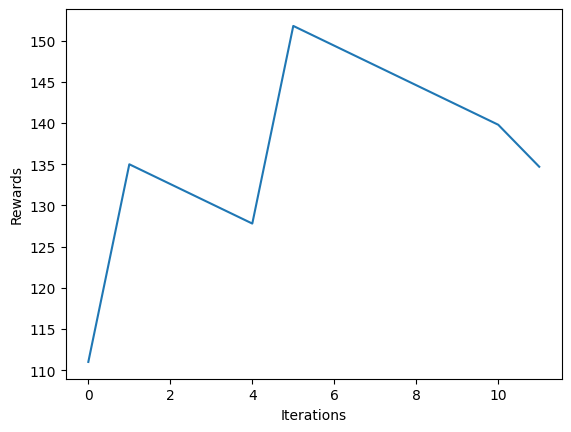

In [72]:
x_plt = []
for i in range(len(r_plt)):
  x_plt.append(i)
plt.plot(x_plt, r_plt)
plt.xlabel("Iterations")
plt.ylabel("Rewards")

The final reward is 134. 70

The same goes with Double Q-Learning as well. But, from the graph, The exploration-exploitation tradeoff is better than the Q-Learning model.

## Deep Q-Network

In [73]:
input_layer_n = num_tasks
output_layer_n = num_tasks
dense_layer_n = 20

In [74]:
dqn_env = env(resources, num_tasks)

In [75]:
model = Sequential()
model.add(InputLayer(batch_input_shape=(1,3)))
model.add(Dense(dense_layer_n, activation='sigmoid'))
model.add(Dense(output_layer_n, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [76]:
#Using epsilon decay
num_job_samples = 1
y = 0.95
eps = 0.5
decay_factor = 0.999
r_avg_list = []
r_plt_dqn = []

In [80]:
for i in range(num_job_samples):
  s = dqn_env.get_initial_state()
  eps *= decay_factor
  scheduled = False
  r_sum = 0

  while not scheduled:
    if np.random.random() < eps:
      print("Randomly selected")
      a = np.random.randint(0, num_tasks)
    else:
      print("Greedily selected")
      temp = model.predict(s)
      idx = np.unravel_index(temp.argmax(), temp.shape)
      idx = list(idx)
      print(temp[idx[0], idx[i]]==temp.max())
      a = idx[0]
    print(a)

    new_s, r, scheduled = dqn_env.get_next_step(a)
    print(np.array(new_s), r, scheduled)

    target = r+y*np.max(model.predict(np.array(new_s)))
    target_vec = model.predict(s)
    target_vec[a] = target

    model.fit(s, target_vec.reshape(-1, num_tasks), epochs=1, verbose=0)
    s = new_s
    r_sum += r
    r_plt_dqn.append(r_sum)

  r_avg_list.append(r_sum/1000)

Randomly selected
1
[[ 0 12 18]
 [ 1 65 77]
 [ 0 31 22]
 [ 0 57 23]
 [ 0 36 11]
 [ 0 27 28]] 142 False
1/1 [==============================] - 0s 22ms/step
Randomly selected
0
[[ 1 12 18]
 [ 1 65 77]
 [ 0 31 22]
 [ 0 57 23]
 [ 0 36 11]
 [ 0 27 28]] -3.0 True
1/1 [==============================] - 0s 16ms/step


In [81]:
print("Total Rewards: ")
print(r_sum)

Total Rewards: 
139.0


Text(0, 0.5, 'Rewards')

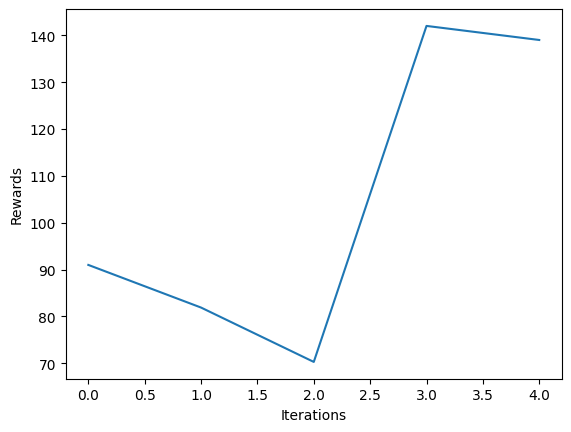

In [82]:
x_plt_dqn = []
for i in range(len(r_plt_dqn)):
  x_plt_dqn.append(i)
plt.plot(x_plt_dqn, r_plt_dqn)
plt.xlabel("Iterations")
plt.ylabel("Rewards")

The final reward is 139.

Deep Q-Network achieves a good tradeoff in the exploration-exploitation conundrum, comparing to Q-Learning and Deep Q-Learning. Thus, helping to achieve maximum resource utilisation.

All the above models can be sampled for n no.of times and the average result can be viewed for better understanding.